# Neural networks 

Een Neuraal Netwerk (in machine learning ook Artificial Neural Network of ANN) is een computer­algoritme dat is geïnspireerd door de werking van het menselijk brein. Het bestaat uit lagen van verbonden rekenelementen (neuronen) die samen patronen in data leren herkennen.

- De inputlaag ontvangt data (bijv. afbeeldingen of tekst).


- Eén of meer verborgen lagen ontdekken complexe patronen.

- De outputlaag geeft het resultaat (bijv. een classificatie of voorspelling).

Tijdens training past het netwerk de gewichten van de verbindingen aan om fouten te verminderen (learning / backpropagation)

Er zijn verschillende soorten neurale netwerken:
- Feedforward-netwerken: Data stroomt in één richting van input naar output.
- Convolutionele neurale netwerken (CNN's): Vooral gebruikt voor beeldherkenning.
- Recurrente neurale netwerken (RNN's): Geschikt voor sequentiële data zoals tekst of spraak.
- Residuale netwerken (ResNets): Helpen bij het trainen van zeer diepe netwerken door 'skip connections'.-
- Generative Adversarial Networks (GAN's): Bestaan uit twee netwerken die tegen elkaar strijden om realistische data te genereren.

Elke type heeft zijn eigen toepassingen en voordelen, afhankelijk van de aard van de data en de specifieke taak die moet worden uitgevoerd.

In deze notebook zal ik een eenvoudig neuraal netwerk implementeren met behulp van Python en de populaire machine learning bibliotheek TensorFlow/Keras. Ik heb FNN (Feedforward Neural Network) gekozen omdat het de basis is van neural networks en geschikt is voor een breed scala aan toepassingen, zoals classificatie en regressie taken. 

## Dataset

Voor deze implementatie zal ik de Bank Marketing Dataset gebruiken, die informatie bevat over marketingcampagnes van een Portugese bank. Het doel is om te voorspellen of een klant een termijndeposito zal openen op basis van verschillende kenmerken zoals leeftijd, werk, balans, etc.


Doel: Voorspellen of een klant een termijndeposito zal openen (ja/nee).


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_curve, auc, accuracy_score, precision_score,
                             recall_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

# TensorFlow en Keras voor het neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical


In [29]:
 #Laad de dataset
df = pd.read_csv('bank.csv')

print(f"Dataset dimensies: {df.shape}")
print(f"Aantal rijen: {df.shape[0]}")
print(f"Aantal kolommen: {df.shape[1]}")
print()

print("Eerste 5 rijen van de dataset:")
print(df.head())
print()

print("Dataset informatie:")
print(df.info())
print()

print("Statistische samenvatting:")
print(df.describe())
print()

print("Ontbrekende waarden per kolom:")
print(df.isnull().sum())
print()

print("Verdeling van de doelvariabele (deposit):")
print(df['deposit'].value_counts())
print(df['deposit'].value_counts(normalize=True))
print()

Dataset dimensies: (11162, 17)
Aantal rijen: 11162
Aantal kolommen: 17

Eerste 5 rijen van de dataset:
   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     ye

In [33]:

# Maak een kopie voor preprocessing
df_processed = df.copy()

# 2.1: Identificeer numerieke en categorische kolommen
print("2.1: Identificatie van kolomtypes")
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

# Verwijder de target variabele uit de features
if 'deposit' in categorical_cols:
    categorical_cols.remove('deposit')

print("-----------------------------------------------")

# 2.2: Encoding van categorische variabelen
print("2.2: Encoding van categorische variabelen")
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"  - {col}: {len(le.classes_)} unieke waarden gecodeerd")


print("-----------------------------------------------")
# 2.3: Encoding van de target variabele
print("2.3: Encoding van de target variabele")
target_encoder = LabelEncoder()
df_processed['deposit'] = target_encoder.fit_transform(df_processed['deposit'])
print(f"  - deposit: 'no' = 0, 'yes' = 1")

print("-----------------------------------------------")
# 2.4: Scheiding van features en target
print("2.4: Scheiding van features en target variabele")
X = df_processed.drop('deposit', axis=1)
y = df_processed['deposit']

print(f"Feature matrix (X) dimensies: {X.shape}")
print(f"Target vector (y) dimensies: {y.shape}")
print(f"Feature namen: {list(X.columns)}")


2.1: Identificatie van kolomtypes
-----------------------------------------------
2.2: Encoding van categorische variabelen
  - job: 12 unieke waarden gecodeerd
  - marital: 3 unieke waarden gecodeerd
  - education: 4 unieke waarden gecodeerd
  - default: 2 unieke waarden gecodeerd
  - housing: 2 unieke waarden gecodeerd
  - loan: 2 unieke waarden gecodeerd
  - contact: 3 unieke waarden gecodeerd
  - month: 12 unieke waarden gecodeerd
  - poutcome: 4 unieke waarden gecodeerd
-----------------------------------------------
2.3: Encoding van de target variabele
  - deposit: 'no' = 0, 'yes' = 1
-----------------------------------------------
2.4: Scheiding van features en target variabele
Feature matrix (X) dimensies: (11162, 16)
Target vector (y) dimensies: (11162,)
Feature namen: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [35]:

# Split de data: 70% training, 15% validatie, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 van 85% = 15% van totaal
)



In [37]:
# Standaardiseer de numerieke features 
#Dat betekent dat we de features schalen zodat ze een gemiddelde van 0 en een standaarddeviatie van 1 hebben.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [38]:

# Bepaal input dimensie
input_dim = X_train_scaled.shape[1]



# Bouw het model
model = models.Sequential([
    # Input layer (impliciet via eerste hidden layer)
    layers.Dense(64, activation='relu', input_shape=(input_dim,), name='hidden_layer_1'),
    layers.Dropout(0.3, name='dropout_1'),
    
    # Tweede hidden layer
    layers.Dense(32, activation='relu', name='hidden_layer_2'),
    layers.Dropout(0.3, name='dropout_2'),
    
    # Derde hidden layer
    layers.Dense(16, activation='relu', name='hidden_layer_3'),
    layers.Dropout(0.2, name='dropout_3'),
    
    # Output layer
    layers.Dense(1, activation='sigmoid', name='output_layer')
])

print("Model samenvatting:")
model.summary()
print()

Model samenvatting:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Compile het model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [40]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6853 - loss: 0.5857 - precision_1: 0.7022 - recall_1: 0.5832 - val_accuracy: 0.8060 - val_loss: 0.4477 - val_precision_1: 0.7563 - val_recall_1: 0.8710
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7727 - loss: 0.4975 - precision_1: 0.7489 - recall_1: 0.7827 - val_accuracy: 0.8257 - val_loss: 0.4261 - val_precision_1: 0.7815 - val_recall_1: 0.8774
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7852 - loss: 0.4772 - precision_1: 0.7567 - recall_1: 0.8059 - val_accuracy: 0.8275 - val_loss: 0.4121 - val_precision_1: 0.7842 - val_recall_1: 0.8774
Epoch 4/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7953 - loss: 0.4668 - precision_1: 0.7662 - recall_1: 0.8175 - val_accuracy: 0.8281 - val_loss: 0.4074 - val_precision_1: 0.7838 - val_recall_1: 0.8799
Epoch 5/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7914 - loss: 0.4638 - precision_1: 0.7566 - recall_1: 0.8

In [41]:

# Evaluatie op test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_test_scaled, y_test, verbose=0
)

print("PRESTATIES OP TEST SET:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")




PRESTATIES OP TEST SET:
  Loss: 0.3778
  Accuracy: 0.8400 (84.00%)
  Precision: 0.7962
  Recall: 0.8904
  F1-Score: 0.8407


In [42]:

# Maak voorspellingen
y_pred_proba = model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

In [44]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("CONFUSION MATRIX:")
print(cm)

print()
print("Interpretatie:")
print(f"  True Negatives (TN): {cm[0,0]}")
print(f"  False Positives (FP): {cm[0,1]}")
print(f"  False Negatives (FN): {cm[1,0]}")
print(f"  True Positives (TP): {cm[1,1]}")
print()


CONFUSION MATRIX:
[[700 181]
 [ 87 707]]

Interpretatie:
  True Negatives (TN): 700
  False Positives (FP): 181
  False Negatives (FN): 87
  True Positives (TP): 707



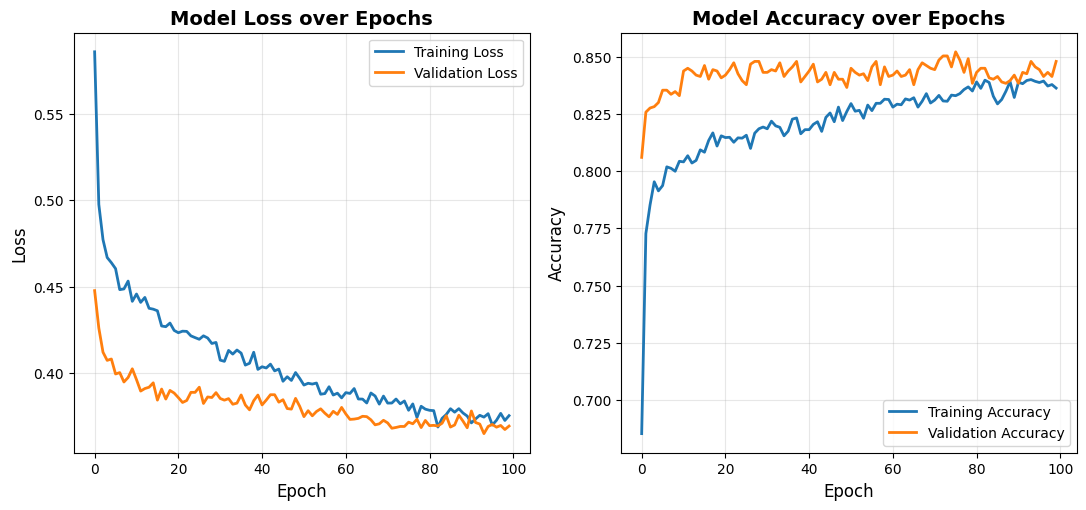

In [46]:

# Maak een figure met subplots
fig = plt.figure(figsize=(20, 12))

# 1. Training en Validatie Loss
ax1 = plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# 2. Training en Validatie Accuracy
ax2 = plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

## Modelen

Er zijn honderden tot duizenden modellen beschikbaar via:

TensorFlow Hub ,Hugging Face Model Hub, PyTorch Hub

Voor tabulaire problemen worden vaak:

-MLP / Dense networks

-Autoencoders

-TabNet / FT-Transformer


Hier is een tabel die de geschatte resourcevereisten voor verschillende soorten modellen samenvat:

| Model                 | Grootte   | RAM        | CPU-tijd (inference) |
| --------------------- | --------- | ---------- | -------------------- |
| Klein FNN (2–3 lagen) | <1 MB     | <50 MB     | <1 ms                |
| Groot MLP             | 5–20 MB   | 100–300 MB | enkele ms            |
| TabTransformer        | 50–200 MB | >500 MB    | cloud                |


---------------------------------------------------------------------------------------------------------   

##  ML op kleine systemen (Raspberry Pi, Coral, Movidius)

Zonder speciale hardware kunnen 

- Draait prima op Raspberry Pi

- Alleen CPU nodig

- Gebruik TensorFlow Lite


Met speciale hardware (zoals Coral of Movidius)

- Snellere inferentie
- Vereist specifieke bibliotheken (bijv. Edge TPU runtime voor Coral)
- Optimaliseer model voor hardware (bijv. quantization)



## Lokale modellen vs cloud services

### Lokale modellen:
- Voordelen:
  - Geen internetverbinding nodig
  - Lagere latentie
  - Meer controle over data en privacy

- Nadelen:

    - Beperkte rekenkracht
    - Moeilijker te schalen
    - Onderhoud en updates zijn eigen verantwoordelijkheid  




### Cloud services:

- Voordelen:
  - Schaalbare rekenkracht
  - Eenvoudig te implementeren en updaten
  - Toegang tot geavanceerde modellen en infrastructuur

- Nadelen:
  - Afhankelijk van internetverbinding  
    - Mogelijke zorgen over data privacy
    - Doorlopende kosten voor gebruik en opslag


    

---------------------------------------------------------------------------------

##  Wiskundige functie trainen met TensorFlow

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi>y</mi><mo>=</mo><mi>a</mi><msup><mi>x</mi><mn>3</mn></msup><mo>+</mo><mi>b</mi><msup><mi>x</mi><mn>2</mn></msup><mo>+</mo><mi>c</mi><mi>x</mi><mo>+</mo><mi>d</mi></mrow><annotation encoding="application/x-tex">y = ax^3 + bx^2 + cx + d</annotation></semantics></math>


Eisen:
 
 -  input laag met 1 neuron
 - 2 hidden lagen met elk 20 neuronen en ReLU activatie
 - output laag met 1 neuron (lineaire activatie)
 - Mean Squared Error (MSE) als verliesfunctie
 - Activatie functie: ReLU voor hidden lagen, lineair voor output laag


 Dit is de code die ik heb gebruikt om het model te trainen:


```



 


In [47]:
import numpy as np
import tensorflow as tf

# Genereer trainingsdata
np.random.seed(42)

X_train = np.random.uniform(-10, 10, (1000, 1))
a, b, c, d = 1, -2, 3, 4    

y_train = a * X_train**3 + b * X_train**2 + c * X_train + d + np.random.normal(0, 10, X_train.shape)
# Bouw het model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)  # Lineaire activatie
])
# Compileer het model
model.compile(optimizer='adam', loss='mse')
# Train het model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


# Evalueer het model
X_test = np.random.uniform(-10, 10, (200, 1))
y_test = a * X_test**3 + b * X_test**2 + c * X_test + d + np.random.normal(0, 10, X_test.shape)
test_loss = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss}")

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 168716.8438   
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166842.0781
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164814.4531 
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162012.7969 
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158148.2344 
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152711.4375 
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 145628.4688
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136606.5781 
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 125697.4062 
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113052.7891
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99186.2891 
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85118.8047 
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71580.9297 
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5959

---------------------------------------------------------------------------------------
##  Google vs Azure vs AWS

Google Vertex AI, Azure Machine Learning en AWS SageMaker zijn drie van de grootste cloudgebaseerde machine learning platforms die bedrijven helpen bij het bouwen, trainen en implementeren van machine learning modellen. Hier is een vergelijkingstabel die enkele van hun sterke punten en geschikte toepassingen samenvat:

| Platform         | Sterk punt        | Geschikt voor  |
| ---------------- | ----------------- | -------------- |
| Google Vertex AI | TensorFlow + TPU  | NN training    |
| Azure ML         | Enterprise & data | Banken         |
| AWS SageMaker    | Schaalbaarheid    | Grote datasets |


--------------------------------------------------------------------------------
## Transformers, GPT, DALL·E

Ze werden oorspronkelijk ontwikkeld voor natuurlijke taalverwerking (NLP) taken, maar hun architectuur is zo krachtig en flexibel dat ze nu worden toegepast op een breed scala aan domeinen, waaronder beeldverwerking, spraakherkenning en zelfs generatieve taken zoals het maken van afbeeldingen (bijv. DALL·E) en tekst (bijv. GPT-series).

### Gebruik voor user

Het gebruik van deze modellen voor gebruikers omvat meestal:

- Toegang via API's: Veel van deze modellen worden aangeboden via API's, waardoor gebruikers eenvoudig toegang hebben zonder de noodzaak om het model zelf te trainen of te hosten.

- Integratie in applicaties: Ontwikkelaars kunnen deze modellen integreren in hun applicaties voor taken zoals tekstgeneratie, vertaling, samenvatting, beeldherkenning, enzovoort.

### kosten

| Model          | Kosten per 1K tokens / afbeeldingen |
| -------------- | ----------------------------------- |
| GPT-3.5        | $0.002                              |
| GPT-4          | $0.03 - $0.12                       |
| DALL·E 2       | $0.02 per afbeelding                |    
--------------------------------------------------------------------------------




## Colab

Colab biedt een gratis Machine Learning modelen omgeving met GPU-ondersteuning, wat het ideaal maakt voor het trainen en testen van neurale netwerken zonder dat je lokale hardware nodig hebt.

Gebruiksgemak



Geen installatie

Gratis GPU/TPU

Perfect voor NN training